In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
print(tf.__version__)

2.4.1


# Saving and loading models

### Loading and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of 60000 color iamges, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

In [37]:
# Import the CIFAR-10 dataset and rescale 
# the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset to speed things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:10000]
y_test = y_test[:10000]

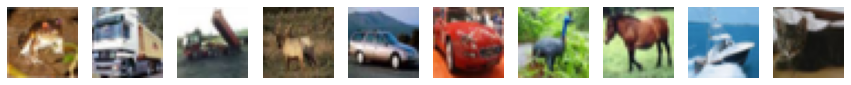

In [3]:
# plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [4]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [5]:
# Introduce function that creates a new instace of a simple CNN

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3),
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3,3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation = 'relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [6]:
# Create an instance of the model and show model summary

model = get_new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
____________________________________________________

In [7]:
get_test_accuracy(model, x_test, y_test)

accuracy: 0.088


#### Train model with checkpoints

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                            frequency='epochs',
                            save_weights_only=True,
                            verbose=1)

In [10]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch

model.fit(x=x_train,
         y=y_train,
         epochs=3,
         callbacks=[checkpoint])

Epoch 1/3
313/313 [==============================] - 3s 9ms/step - loss: 2.0330 - accuracy: 0.2528

Epoch 00001: saving model to model_checkpoints/checkpoint
Epoch 2/3
313/313 [==============================] - 3s 9ms/step - loss: 1.6804 - accuracy: 0.3914

Epoch 00002: saving model to model_checkpoints/checkpoint
Epoch 3/3
313/313 [==============================] - 3s 9ms/step - loss: 1.5543 - accuracy: 0.4367

Epoch 00003: saving model to model_checkpoints/checkpoint


In [11]:
# Have a look at what the checkpoint creates

! ls -1h  model_checkpoints

checkpoint
checkpoint.data-00000-of-00001
checkpoint.index


In [12]:
# Evaluate the performance of the trained model

get_test_accuracy(model, x_test, y_test)

accuracy: 0.438


#### Create new model, load weights

In [13]:
# Create a new instace of the (initialised) model, accuracy around 10% again

model = get_new_model()
get_test_accuracy(model, x_test, y_test)

accuracy: 0.100


In [14]:
# Load weights -- accuracy is the same as the trained model

model.load_weights(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.438


#### Clear directory

In [15]:
! rm -r model_checkpoints

# Model saving criteria

### Create more customised checkpoint

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [17]:
# Create Tensforflow checkpoint object with epochs and batch details

checkpoint_5000_path = 'model_checkpoints_5000/checkpoint_{epoch:03d}_{batch:04d}'
checkpoint_5000 = ModelCheckpoint(filepath=checkpoint_5000_path,
                                 save_weights_only=True,
                                  save_freq=5000,
                                  verbose=1)

In [18]:
model = get_new_model()
model.fit(x=x_train,
         y=y_train,
          epochs=3,
          validation_data=(x_test, y_test),
          batch_size=10,
          callbacks=[checkpoint_5000])

Epoch 1/3
1000/1000 [==============================] - 6s 6ms/step - loss: 2.0276 - accuracy: 0.2352 - val_loss: 1.5713 - val_accuracy: 0.4332
Epoch 2/3
1000/1000 [==============================] - 5s 5ms/step - loss: 1.5504 - accuracy: 0.4349 - val_loss: 1.5055 - val_accuracy: 0.4626
Epoch 3/3
1000/1000 [==============================] - 5s 5ms/step - loss: 1.4034 - accuracy: 0.4914 - val_loss: 1.4818 - val_accuracy: 0.4749


In [19]:
! ls -lh model_checkpoints_5000

ls: cannot access 'model_checkpoints_5000': No such file or directory


#### Work with model saving criteria

In [20]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [21]:
# Create a new instance of untrained model

model = get_new_model()

In [22]:
# Create Tensorflow checkpoint object which monitors the validation accuracy

checkpoint_best_path = 'model_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                 save_weights_only=True,
                                 save_frequency='epoch',
                                 monitor='val_accuracy',
                                 save_best_only=True,
                                 verbose=1)

In [24]:
# Fit the model and save only the weights with the highest validation accuracy

history = model.fit(x = x_train,
                   y = y_train,
                   epochs = 50,
                   validation_data = (x_test, y_test),
                   batch_size = 10,
                   callbacks=[checkpoint_best],
                   verbose=0)


Epoch 00001: val_accuracy improved from -inf to 0.14000, saving model to model_checkpoints_best/checkpoint

Epoch 00002: val_accuracy did not improve from 0.14000

Epoch 00003: val_accuracy did not improve from 0.14000

Epoch 00004: val_accuracy did not improve from 0.14000

Epoch 00005: val_accuracy did not improve from 0.14000

Epoch 00006: val_accuracy did not improve from 0.14000

Epoch 00007: val_accuracy did not improve from 0.14000

Epoch 00008: val_accuracy did not improve from 0.14000

Epoch 00009: val_accuracy did not improve from 0.14000

Epoch 00010: val_accuracy did not improve from 0.14000

Epoch 00011: val_accuracy did not improve from 0.14000

Epoch 00012: val_accuracy improved from 0.14000 to 0.16000, saving model to model_checkpoints_best/checkpoint

Epoch 00013: val_accuracy did not improve from 0.16000

Epoch 00014: val_accuracy improved from 0.16000 to 0.17000, saving model to model_checkpoints_best/checkpoint

Epoch 00015: val_accuracy improved from 0.17000 to 0.

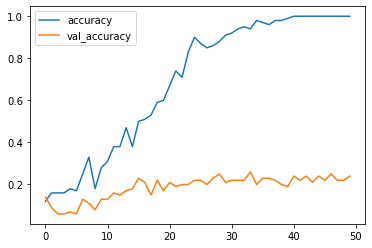

In [25]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [28]:
# Inspect the checkpoint directory

! ls -lh model_checkpoints_best

total 184K
-rw-rw-r-- 1 mach1ne mach1ne   77 fev 12 11:04 checkpoint
-rw-rw-r-- 1 mach1ne mach1ne 174K fev 12 11:04 checkpoint.data-00000-of-00001
-rw-rw-r-- 1 mach1ne mach1ne 2,0K fev 12 11:04 checkpoint.index


In [29]:
# Create a new model with the saved weights

new_model = get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.260


# Saving the entire model

### Create checkpoint that saves the whole model, not just the weights

In [30]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                            save_weights_only=False,
                            frequency='epoch',
                            verbose=1)

In [38]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x=x_train,
         y=y_train,
         epochs=3,
         callbacks=[checkpoint])

Epoch 1/3
313/313 [==============================] - 3s 9ms/step - loss: 2.1512 - accuracy: 0.1979

Epoch 00001: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
Epoch 2/3
313/313 [==============================] - 3s 9ms/step - loss: 1.6595 - accuracy: 0.4080

Epoch 00002: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
Epoch 3/3
313/313 [==============================] - 3s 9ms/step - loss: 1.5405 - accuracy: 0.4533

Epoch 00003: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets


In [39]:
# Have a look at what the checkpoint creates

! ls -lh model_checkpoints

total 136K
drwxr-xr-x 2 mach1ne mach1ne 4,0K fev 12 11:21 assets
-rw-rw-r-- 1 mach1ne mach1ne 127K fev 12 11:24 saved_model.pb
drwxr-xr-x 2 mach1ne mach1ne 4,0K fev 12 11:24 variables


In [40]:
! ls -lh model_checkpoints/variables

total 184K
-rw-rw-r-- 1 mach1ne mach1ne 177K fev 12 11:24 variables.data-00000-of-00001
-rw-rw-r-- 1 mach1ne mach1ne 2,2K fev 12 11:24 variables.index


In [41]:
# Get the model test accuracy

get_test_accuracy(model, x_test, y_test)

accuracy: 0.452


### Create new model from scratch

In [46]:
# Delete model

del model

In [48]:
from tensorflow.keras.models import load_model

In [50]:
# Reload model from scratch

model = load_model(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.452


In [53]:
# Save the model in .h5 format

model.save('my_model.h5')

In [55]:
! ls -lh my_model.h5

-rw-rw-r-- 1 mach1ne mach1ne 77K fev 12 11:27 my_model.h5


In [57]:
# Delete model

del model

In [59]:
# Reload from scratch

model = load_model('my_model.h5')
get_test_accuracy(model, x_test, y_test)

accuracy: 0.452


### Clear directory

In [60]:
! rm -r model_checkpoints
! rm my_model.h5